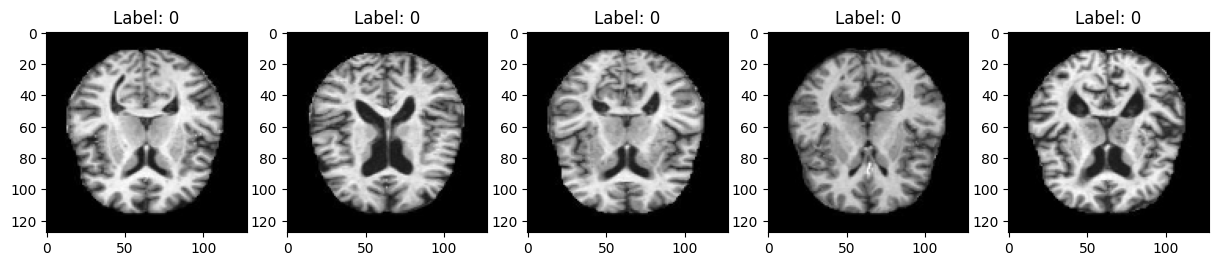

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directory paths for demented and non-demented images
demented_dir = (r"C:\Users\sukis\Downloads\OriginalDataset\ModerateDemented")
non_demented_dir = (r"C:\Users\sukis\Downloads\OriginalDataset\NonDemented")

# Load the dataset and preprocess
def load_images(directory, label, img_size=(128, 128)):
    images = []
    labels = []
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        image = cv2.imread(img_path)
        image = cv2.resize(image, img_size)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Grayscale conversion
        images.append(image)
        labels.append(label)
    return np.array(images), np.array(labels)

# Load both classes
demented_images, demented_labels = load_images(demented_dir, label=1)
non_demented_images, non_demented_labels = load_images(non_demented_dir, label=0)

# Combine datasets
X = np.concatenate((demented_images, non_demented_images), axis=0)
y = np.concatenate((demented_labels, non_demented_labels), axis=0)

# Normalize and expand dims for channel
X = X / 255.0
X = np.expand_dims(X, axis=-1)

# Split into train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(rotation_range=10, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
datagen.fit(X_train)

# Visualization of sample images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(X_train[i].squeeze(), cmap='gray')
    axes[i].set_title(f"Label: {y_train[i]}")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step


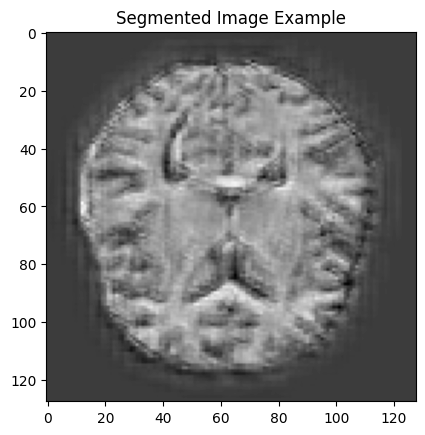

In [2]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model

def unet_model(input_shape=(128, 128, 1)):
    inputs = Input(input_shape)
    
    # Downsampling
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    
    # Bottleneck
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    
    # Upsampling
    u1 = UpSampling2D((2, 2))(c3)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    concat1 = Concatenate()([c4, c2])
    
    u2 = UpSampling2D((2, 2))(concat1)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    concat2 = Concatenate()([c5, c1])
    
    # Output layer (segmentation map)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(concat2)
    
    return Model(inputs, outputs)

# Initialize and compile U-Net model
unet = unet_model()
unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Example of using the U-Net for segmentation
segmented_image = unet.predict(np.expand_dims(X_train[0], axis=0))
plt.imshow(segmented_image[0].squeeze(), cmap='gray')
plt.title('Segmented Image Example')
plt.show()


In [2]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# SE-ResNet for feature extraction
se_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the SE-ResNet layers
for layer in se_resnet.layers:
    layer.trainable = False

# Add global pooling and dense layers for classification
x = GlobalAveragePooling2D()(se_resnet.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=se_resnet.input, outputs=x)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Convert grayscale images to 3-channel RGB
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

# Use data generator to manage large dataset training
train_gen = datagen.flow(X_train_rgb, y_train, batch_size=8)

# Train the model
history = model.fit(train_gen, epochs=20, validation_data=(X_test_rgb, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_rgb, y_test)
print(f'Test Accuracy: {accuracy:.2f}')


NameError: name 'Model' is not defined